In [1]:
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [2]:
patient = "A0NVTRV"
mr = "25"
n = 10
mr_values = [10, 20, 30, 40, 50]

df_full = pd.read_csv(f'{patient}/Anomalies/{patient}_offline_anomalies.csv', usecols=[2], header=None)
dfs_miss = {}
for mr_value in mr_values:
    dfs_miss[mr_value] = {}
    for i in range(1, n + 1):
        file_path = f'{patient}/Anomalies/MCAR/{mr_value}/{patient}_offline_anomalies_MCAR_{mr_value}_{i}.csv'
        if os.path.getsize(file_path) > 0:
            dfs_miss[mr_value][i] = pd.read_csv(file_path, usecols=[2], header=None)
        else:
            print(f"O arquivo {file_path} está vazio")

O arquivo A0NVTRV/Anomalies/MCAR/40/A0NVTRV_offline_anomalies_MCAR_40_10.csv está vazio
O arquivo A0NVTRV/Anomalies/MCAR/50/A0NVTRV_offline_anomalies_MCAR_50_1.csv está vazio
O arquivo A0NVTRV/Anomalies/MCAR/50/A0NVTRV_offline_anomalies_MCAR_50_3.csv está vazio
O arquivo A0NVTRV/Anomalies/MCAR/50/A0NVTRV_offline_anomalies_MCAR_50_4.csv está vazio
O arquivo A0NVTRV/Anomalies/MCAR/50/A0NVTRV_offline_anomalies_MCAR_50_6.csv está vazio
O arquivo A0NVTRV/Anomalies/MCAR/50/A0NVTRV_offline_anomalies_MCAR_50_7.csv está vazio
O arquivo A0NVTRV/Anomalies/MCAR/50/A0NVTRV_offline_anomalies_MCAR_50_8.csv está vazio
O arquivo A0NVTRV/Anomalies/MCAR/50/A0NVTRV_offline_anomalies_MCAR_50_9.csv está vazio


Exibindo o PDF: A0NVTRV/Figures/A0NVTRV_offline.pdf


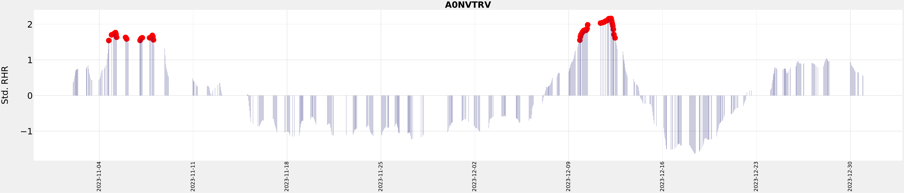

Exibindo o PDF: A0NVTRV/Figures/MCAR/50/A0NVTRV_offline_MCAR_50_1.pdf


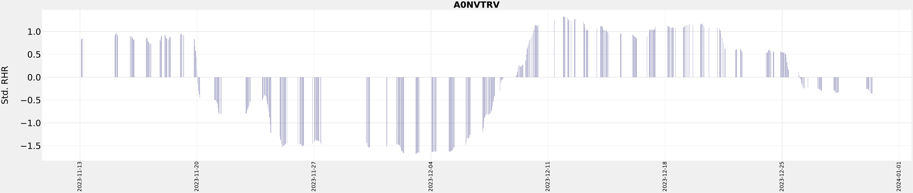

In [3]:
from IPython.display import display
from PIL import Image as PILImage
from io import BytesIO
from pdf2image import convert_from_path

# Listar arquivos PDF no diretório especificado
pdf_dir = f'{patient}/Figures/'
pdf_file1 = f'{patient}_offline.pdf'
pdf_file2 = f'MCAR/50/{patient}_offline_MCAR_50_1.pdf'


# Mostrar os dois PDFs como imagens
for pdf_file in [pdf_file1, pdf_file2]:
    pdf_path = os.path.join(pdf_dir, pdf_file)
    print(f"Exibindo o PDF: {pdf_path}")
    
    # Converter o PDF para imagens
    images = convert_from_path(pdf_path, dpi=100)
    
    # Exibir as imagens
    for i, image in enumerate(images):

        # Reduzir o tamanho da imagem
        resized_image = image.resize((image.width // 8, image.height // 8))

        # Converter a imagem para bytes
        img_bytes = BytesIO()
        resized_image.save(img_bytes, format="PNG")  # Salva em formato PNG (ou outro formato suportado)
        img_bytes.seek(0)

        # Exibir a imagem corretamente
        display(PILImage.open(img_bytes))  # Agora o objeto está no formato correto


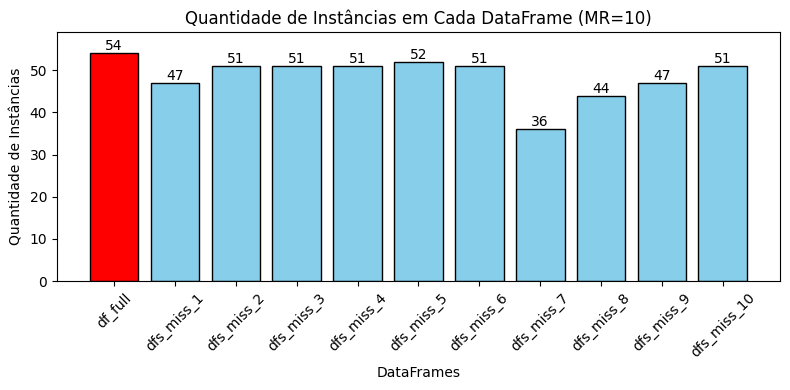

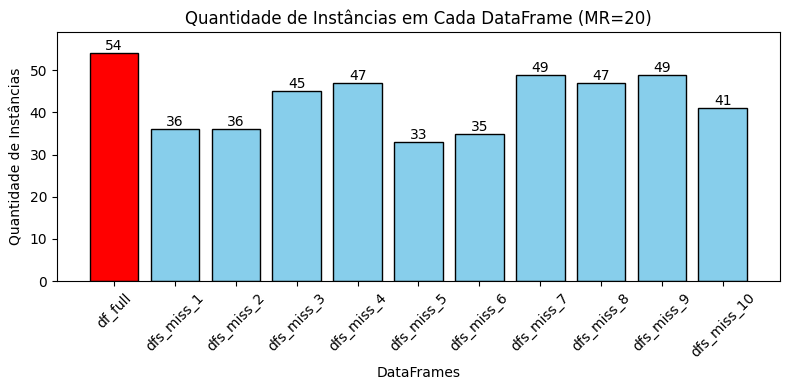

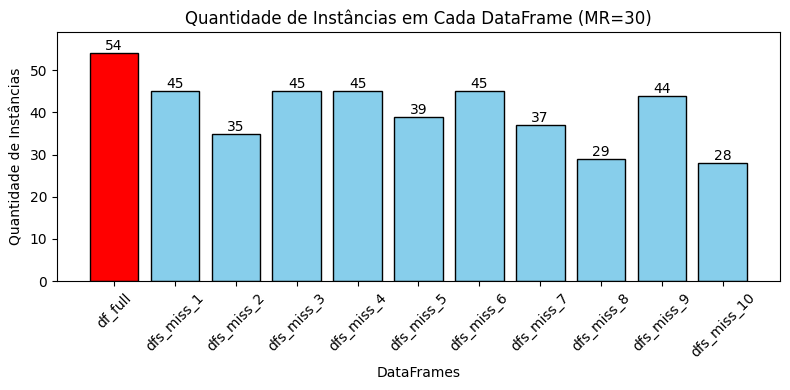

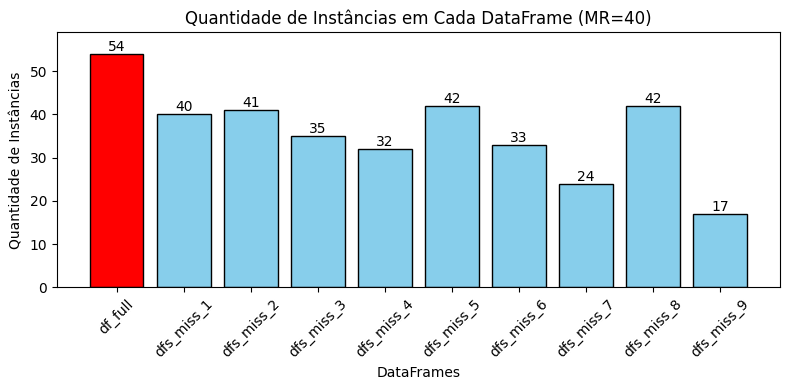

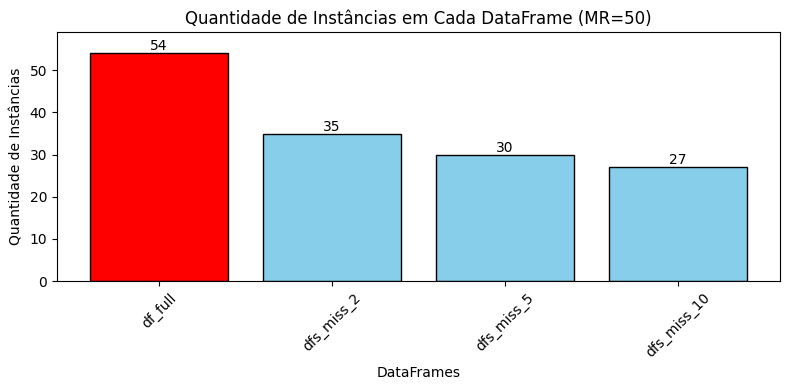

In [4]:
# Determinar o limite máximo para o eixo Y
max_instances = max(len(df_full), max(len(dfs[i]) for dfs in dfs_miss.values() for i in dfs.keys()))

# Criar um gráfico de barras para cada MR
for mr_value, dfs in dfs_miss.items():
    plt.figure(figsize=(8, 4))
    
    # Adicionar o tamanho de df_full ao dicionário de tamanhos
    sizes = {'df_full': len(df_full)}  # Tamanho de df_full
    sizes.update({f'dfs_miss_{i}': len(dfs[i]) for i in dfs.keys()})
    
    # Definir as cores das barras
    colors = ['red' if key == 'df_full' else 'skyblue' for key in sizes.keys()]
    
    # Criar as barras
    bars = plt.bar(sizes.keys(), sizes.values(), color=colors, edgecolor='black')

    # Adicionar os valores em cima das barras
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

    # Configurar o título e os rótulos
    plt.title(f'Quantidade de Instâncias em Cada DataFrame (MR={mr_value})')
    plt.xlabel('DataFrames')
    plt.ylabel('Quantidade de Instâncias')
    plt.xticks(rotation=45)
    
    # Definir o mesmo limite para o eixo Y
    plt.ylim(0, max_instances + 5)

    # Ajustar o layout
    plt.tight_layout()
    plt.show()


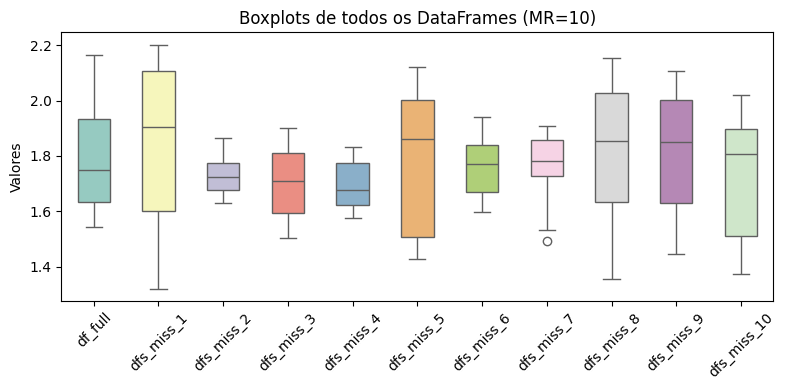

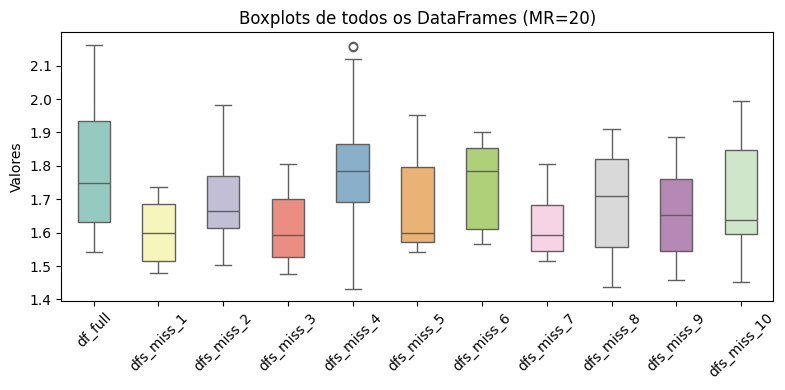

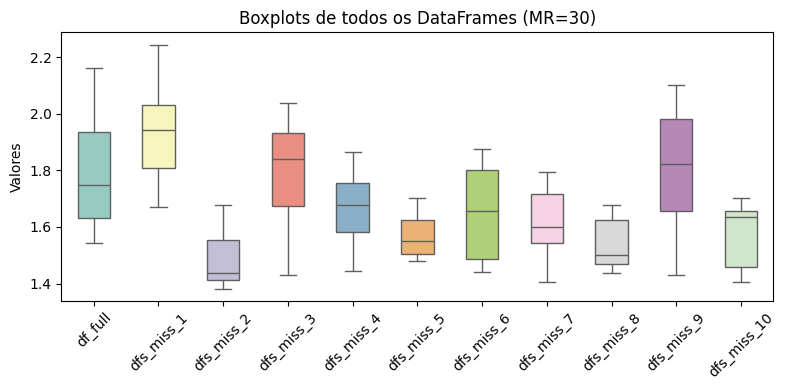

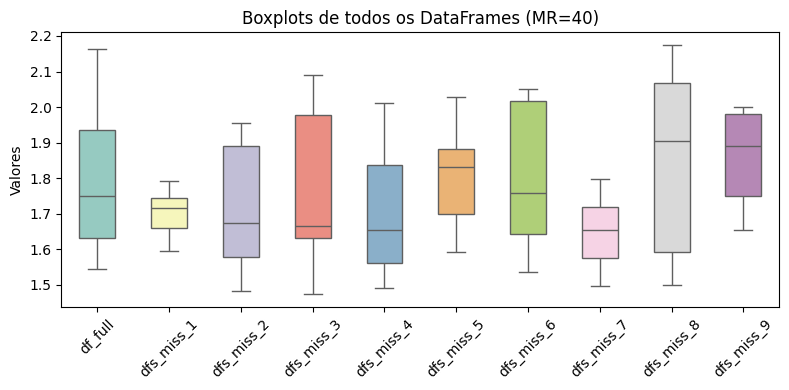

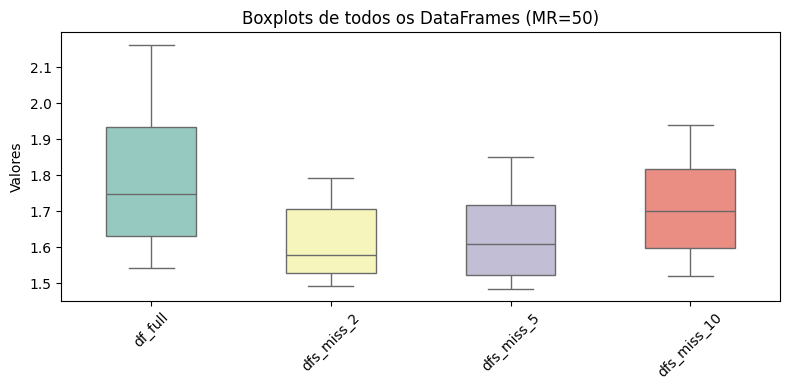

In [5]:
# Loop para gerar boxplots para cada valor de MR
for mr in mr_values:
    # Obter os dados de df_full e dfs_miss para o MR atual
    data = [df_full.iloc[:, 0].values] + [df.iloc[:, 0].values for df in dfs_miss[mr].values()]
    
    # Criar os rótulos correspondentes
    labels = ['df_full'] + [f'dfs_miss_{i}' for i in dfs_miss[mr].keys()]
    
    # Criar o boxplot
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=data, palette='Set3', width=0.5)
    
    # Ajustar o título e os rótulos
    plt.title(f'Boxplots de todos os DataFrames (MR={mr})')
    plt.ylabel('Valores')
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    
    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()


In [6]:
# Realizar o teste de Kolmogorov-Smirnov para todos os valores de MR
for mr, dfs in dfs_miss.items():
    # Inicializar contadores para cada MR
    rejeitaram = 0
    aceitaram = 0
    
    print(f"Resultados do teste de Kolmogorov-Smirnov (KS) para MR={mr}:")
    
    # Aplicar o teste de Kolmogorov-Smirnov para cada DataFrame em dfs_miss[mr]
    for key, df_miss in dfs.items():
        ks_stat, ks_p_value = scipy.stats.kstest(df_full.iloc[:, 0], df_miss.iloc[:, 0], alternative='two-sided')
        
        # Exibir os resultados detalhados para cada DataFrame
        # print(f"  dfs_miss[{key}]:")
        # print(f"    Estatística KS: {ks_stat}")
        # print(f"    Valor-p: {ks_p_value}")
        
        if ks_p_value > 0.01:
            # print("    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).")
            aceitaram += 1
        else:
            # print("    Rejeitamos a hipótese nula (as distribuições são diferentes).")
            rejeitaram += 1
        # print()
    
    # Calcular porcentagens para o MR atual
    total = rejeitaram + aceitaram
    porcentagem_rejeitaram = (rejeitaram / total) * 100
    porcentagem_aceitaram = (aceitaram / total) * 100
    
    # Exibir resumo final para o MR atual
    # print(f"Resumo final para MR={mr}:")
    print(f"  As distribuições são diferentes: {rejeitaram} ({porcentagem_rejeitaram:.2f}%)")
    print(f"  As distribuições são semelhantes: {aceitaram} ({porcentagem_aceitaram:.2f}%)")
    print()

Resultados do teste de Kolmogorov-Smirnov (KS) para MR=10:
  As distribuições são diferentes: 3 (30.00%)
  As distribuições são semelhantes: 7 (70.00%)

Resultados do teste de Kolmogorov-Smirnov (KS) para MR=20:
  As distribuições são diferentes: 4 (40.00%)
  As distribuições são semelhantes: 6 (60.00%)

Resultados do teste de Kolmogorov-Smirnov (KS) para MR=30:
  As distribuições são diferentes: 7 (70.00%)
  As distribuições são semelhantes: 3 (30.00%)

Resultados do teste de Kolmogorov-Smirnov (KS) para MR=40:
  As distribuições são diferentes: 2 (22.22%)
  As distribuições são semelhantes: 7 (77.78%)

Resultados do teste de Kolmogorov-Smirnov (KS) para MR=50:
  As distribuições são diferentes: 2 (66.67%)
  As distribuições são semelhantes: 1 (33.33%)



In [7]:
# Realizar o teste de Mann-Whitney U para todos os valores de MR
for mr, dfs in dfs_miss.items():
    # Inicializar contadores para cada MR
    rejeitaram = 0
    aceitaram = 0
    
    print(f"Resultados do teste de Mann-Whitney U para MR={mr}:")
    
    # Aplicar o teste de Mann-Whitney U para cada DataFrame em dfs_miss[mr]
    for key, df_miss in dfs.items():
        u_stat, p_value = scipy.stats.mannwhitneyu(df_full.iloc[:, 0], df_miss.iloc[:, 0], alternative='two-sided')
        
        # Exibir os resultados detalhados para cada DataFrame
        # print(f"  dfs_miss[{key}]:")
        # print(f"    Estatística U: {u_stat}")
        # print(f"    Valor-p: {p_value}")
        
        if p_value > 0.05:
            # print("    Não há evidências suficientes para rejeitar a hipótese nula (as distribuições são semelhantes).")
            aceitaram += 1
        else:
            # print("    Rejeitamos a hipótese nula (as distribuições são diferentes).")
            rejeitaram += 1
        # print()
    
    # Calcular porcentagens para o MR atual
    total = rejeitaram + aceitaram
    porcentagem_rejeitaram = (rejeitaram / total) * 100
    porcentagem_aceitaram = (aceitaram / total) * 100
    
    # Exibir resumo final para o MR atual
    # print(f"Resumo final para MR={mr}:")
    print(f"  As distribuições são diferentes: {rejeitaram} ({porcentagem_rejeitaram:.2f}%)")
    print(f"  As distribuições são semelhantes: {aceitaram} ({porcentagem_aceitaram:.2f}%)")
    print()

Resultados do teste de Mann-Whitney U para MR=10:
  As distribuições são diferentes: 2 (20.00%)
  As distribuições são semelhantes: 8 (80.00%)

Resultados do teste de Mann-Whitney U para MR=20:
  As distribuições são diferentes: 8 (80.00%)
  As distribuições são semelhantes: 2 (20.00%)

Resultados do teste de Mann-Whitney U para MR=30:
  As distribuições são diferentes: 8 (80.00%)
  As distribuições são semelhantes: 2 (20.00%)

Resultados do teste de Mann-Whitney U para MR=40:
  As distribuições são diferentes: 3 (33.33%)
  As distribuições são semelhantes: 6 (66.67%)

Resultados do teste de Mann-Whitney U para MR=50:
  As distribuições são diferentes: 2 (66.67%)
  As distribuições são semelhantes: 1 (33.33%)



In [8]:
# Realizar o teste de Levene para todos os valores de MR
for mr, dfs in dfs_miss.items():
    # Inicializar contadores para cada MR
    rejeitaram = 0
    aceitaram = 0
    
    print(f"Resultados do teste de Levene para MR={mr}:")
    
    # Aplicar o teste de Levene para cada DataFrame em dfs_miss[mr]
    for key, df_miss in dfs.items():
        stat, p_value = scipy.stats.levene(df_full.iloc[:, 0], df_miss.iloc[:, 0])
        
        # Exibir os resultados detalhados para cada DataFrame
        # print(f"  dfs_miss[{key}]:")
        # print(f"    Estatística: {stat}")
        # print(f"    Valor-p: {p_value}")
        
        if p_value > 0.05:
            # print("    Não há evidências suficientes para rejeitar a hipótese nula (as variâncias são semelhantes).")
            aceitaram += 1
        else:
            # print("    Rejeitamos a hipótese nula (as variâncias são diferentes).")
            rejeitaram += 1
        # print()
    
    # Calcular porcentagens para o MR atual
    total = rejeitaram + aceitaram
    porcentagem_rejeitaram = (rejeitaram / total) * 100
    porcentagem_aceitaram = (aceitaram / total) * 100
    
    # Exibir resumo final para o MR atual
    # print(f"Resumo final para MR={mr}:")
    print(f"  As variâncias são diferentes: {rejeitaram} ({porcentagem_rejeitaram:.2f}%)")
    print(f"  As variâncias são semelhantes: {aceitaram} ({porcentagem_aceitaram:.2f}%)")
    print()

    


Resultados do teste de Levene para MR=10:
  As variâncias são diferentes: 7 (70.00%)
  As variâncias são semelhantes: 3 (30.00%)

Resultados do teste de Levene para MR=20:
  As variâncias são diferentes: 6 (60.00%)
  As variâncias são semelhantes: 4 (40.00%)

Resultados do teste de Levene para MR=30:
  As variâncias são diferentes: 6 (60.00%)
  As variâncias são semelhantes: 4 (40.00%)

Resultados do teste de Levene para MR=40:
  As variâncias são diferentes: 4 (44.44%)
  As variâncias são semelhantes: 5 (55.56%)

Resultados do teste de Levene para MR=50:
  As variâncias são diferentes: 2 (66.67%)
  As variâncias são semelhantes: 1 (33.33%)



In [9]:
def intervals_overlap(a, b):
    """Verifica se os intervalos a e b se sobrepõem"""
    return max(a[0], b[0]) <= min(a[1], b[1])

def match_event_intervals(y_true, y_pred):
    """
    Compara listas de intervalos (eventos reais e previstos).
    Cada intervalo é uma tupla: (inicio, fim)

    Retorna TP, FP, FN
    """
    matched_true = set()
    matched_pred = set()

    for i, pred in enumerate(y_pred):
        for j, true in enumerate(y_true):
            if intervals_overlap(pred, true):
                matched_pred.add(i)
                matched_true.add(j)
                break  # conta só uma correspondência

    TP = len(matched_pred)
    FP = len(y_pred) - TP
    FN = len(y_true) - len(matched_true)

    return TP, FP, FN

In [15]:
from tqdm import tqdm

# Listar todos os pacientes na pasta RHR_offline
patients = [patient for patient in os.listdir('.') if os.path.isdir(patient)]

# Iterar sobre cada paciente e realizar o processamento
results = {}
absolute = {}

# Adicionar barra de progresso
for patient in tqdm(patients, desc="Processando pacientes"):
    # print(f"Processando paciente: {patient}")
    
    # Carregar df_full
    try:
        df_full = pd.read_csv(f'{patient}/Anomalies/{patient}_offline_anomalies.csv', usecols=[1, 2], header=None)
    except (FileNotFoundError, pd.errors.EmptyDataError):
        continue
    
    # Inicializar dfs_miss
    dfs_miss = {}
    for mr_value in mr_values:
        dfs_miss[mr_value] = {}
        for i in range(1, n + 1):
            file_path = f'{patient}/Anomalies/MCAR/{mr_value}/{patient}_offline_anomalies_MCAR_{mr_value}_{i}.csv'
            if os.path.getsize(file_path) > 0:
                dfs_miss[mr_value][i] = pd.read_csv(file_path, usecols=[1, 2], header=None)
            else:
                continue
    
    # Realizar o processamento necessário para cada paciente
    precision_list = []
    recall_list = []

    for mr, dfs in dfs_miss.items():
        for key, df_miss in dfs.items():
            y_true_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in zip(df_full[1], df_full[1])]
            y_pred_intervals = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in zip(df_miss[1], df_miss[1])]

            TP, FP, FN = match_event_intervals(y_true_intervals, y_pred_intervals)

            if mr not in absolute:
                absolute[mr] = {'TP': [], 'FP': [], 'FN': []}
            absolute[mr]['TP'].append(TP)
            absolute[mr]['FP'].append(FP)
            absolute[mr]['FN'].append(FN)

            precision = TP / (TP + FP) if (TP + FP) > 0 else 0
            recall = TP / (TP + FN) if (TP + FN) > 0 else 0

            precision_list.append(precision)
            recall_list.append(recall)

    mean_precision_by_mr = {mr: np.mean([precision_list[i] for i in range(len(precision_list)) if mr_values[i // n] == mr]) for mr in mr_values}
    mean_recall_by_mr = {mr: np.mean([recall_list[i] for i in range(len(recall_list)) if mr_values[i // n] == mr]) for mr in mr_values}

    for mr in mr_values:
        if mr not in results:
            results[mr] = {'precision': [], 'recall': []}
        results[mr]['precision'].append(mean_precision_by_mr[mr])
        results[mr]['recall'].append(mean_recall_by_mr[mr])


Processando pacientes:   9%|▉         | 3/32 [00:10<01:37,  3.36s/it]/srv12t/afonso/Experiment/Results/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv12t/afonso/Experiment/Results/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processando pacientes:  16%|█▌        | 5/32 [00:13<01:01,  2.28s/it]/srv12t/afonso/Experiment/Results/.venv/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/srv12t/afonso/Experiment/Results/.venv/lib/python3.10/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Processando pacientes:  25%|██▌       | 8/32 [00:15<00:29,  1.21s/it]/srv12t/afonso/Experiment

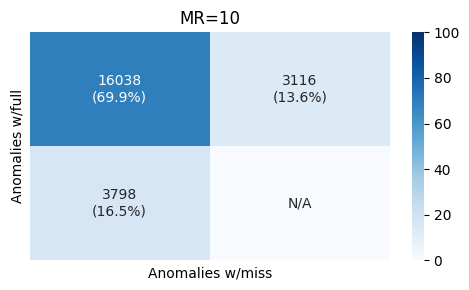

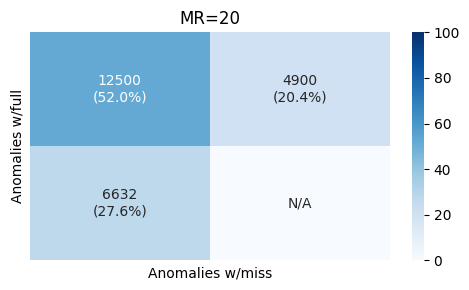

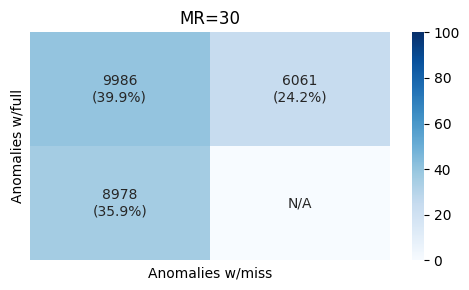

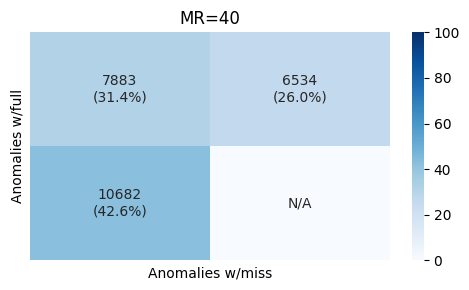

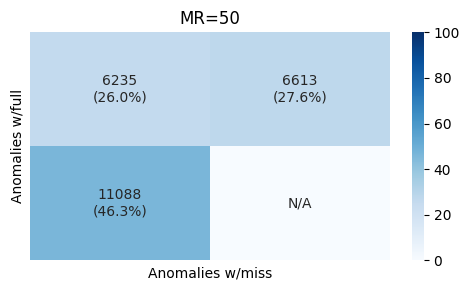

In [ ]:
# Inicializar os valores totais de TP, FP, FN
# Inicializar os valores totais de TP, FP, FN por MR
total_tp_by_mr = {mr: sum(values['TP']) for mr, values in absolute.items()}
total_fp_by_mr = {mr: sum(values['FP']) for mr, values in absolute.items()}
total_fn_by_mr = {mr: sum(values['FN']) for mr, values in absolute.items()}

# Criar a matriz de confusão para cada MR
# Determinar o intervalo global para o cbar_kws
min_value = min(
    total_tp_by_mr[mr] / (total_tp_by_mr[mr] + total_fp_by_mr[mr] + total_fn_by_mr[mr]) * 100
    for mr in mr_values
)
max_value = max(
    total_tp_by_mr[mr] / (total_tp_by_mr[mr] + total_fp_by_mr[mr] + total_fn_by_mr[mr]) * 100
    for mr in mr_values
)

# Criar a matriz de confusão para cada MR
for mr in mr_values:
    # Calcular a matriz de confusão em porcentagem
    total = total_tp_by_mr[mr] + total_fp_by_mr[mr] + total_fn_by_mr[mr]
    confusion_matrix_percentage = np.array([[total_tp_by_mr[mr] / total * 100, total_fp_by_mr[mr] / total * 100],
                                             [total_fn_by_mr[mr] / total * 100, 0]])  # TN não está disponível

    # Criar a matriz de confusão com valores absolutos e porcentagens
    confusion_matrix_text = np.array([[f"{total_tp_by_mr[mr]}\n({total_tp_by_mr[mr] / total * 100:.1f}%)", 
                                        f"{total_fp_by_mr[mr]}\n({total_fp_by_mr[mr] / total * 100:.1f}%)"],
                                       [f"{total_fn_by_mr[mr]}\n({total_fn_by_mr[mr] / total * 100:.1f}%)", "N/A"]])

    # Visualizar a matriz de confusão como um mapa de calor
    plt.figure(figsize=(5, 3))
    sns.heatmap(confusion_matrix_percentage, annot=confusion_matrix_text, fmt='', cmap='Blues', cbar=True, 
                xticklabels=False, 
                yticklabels=False,
                vmax=100, vmin=0)
    plt.title(f"MR={mr}")
    plt.xlabel("Anomalies w/miss")
    plt.ylabel("Anomalies w/full")
    plt.tight_layout()
    plt.show()

In [19]:

# Inicializar listas para armazenar as métricas
accuracy_list = []
precision_list = []
f1_list = []
recall_list = []

# Calcular métricas para cada MR
for mr in mr_values:
    tp = total_tp_by_mr[mr]
    fp = total_fp_by_mr[mr]
    fn = total_fn_by_mr[mr]
    total_instances = tp + fp + fn

    # Calcular acurácia, precisão, revocação e F1
    accuracy = tp / total_instances if total_instances > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Adicionar métricas às listas
    accuracy_list.append(accuracy * 100)
    precision_list.append(precision * 100)
    recall_list.append(recall * 100)
    f1_list.append(f1 * 100)

# Criar um DataFrame com as métricas
metrics_table = pd.DataFrame({
    'MR': mr_values,
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1 Score': f1_list
})

# Exibir a tabela
print(metrics_table)

   MR   Accuracy  Precision     Recall   F1 Score
0  10  69.876264  83.731858  80.852995  82.267248
1  20  52.013981  71.839080  65.335563  68.433154
2  30  39.904096  62.229700  52.657667  57.044929
3  40  31.407626  54.678505  42.461621  47.801831
4  50  26.048630  48.528954  35.992611  41.331080
